### An example of using the emcee package for MCMC

This is really a ridiculous use of emcee, but the purpose of this example is to show the
mechanics of the package.  Clearly any simple fitting of a polynomial to a data set where
you can believe the measurement errors should be done via other much more appropriate
approaches.

That being said, the example is below.  Going through the whole thing will show you
not just a use of emcee but, nearly at the end, how to turn a MCMC chain into a nice corner
plot.

To run the code, you will first need to download and install both the emcee and corner.py packages.
  * emcee can be found at http://dan.iel.fm/emcee/current/
  * corner.py can be found at http://corner.readthedocs.io/en/latest/index.html

In [1]:
""" Import necessary packages, including emcee """
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.io import ascii
from math import log
import emcee
import corner # For making a nice plot at the end

In [2]:
""" Set up the path to your data.  Change as needed """
datadir = 'Data'

**NOTE** emcee requires at least one function that will evaluate a model and return a
probability.  You will for sure need a function that returns the likelihood of a given
model, and you should also have functions for the priors and the posterior.  You can
probably combine these all into one function, but I may be missing something.

**Important** All of these functions must have as their first input the array that
contains the parameters that are being varied in the fit.  Other things that are 
important, such as x, y, and yerr, come after that.

In [3]:
"""
Set up the likelihood function.  Inputs are the parameter vector, and then x, y, and yerr. 
"""

def lnlikelihood(pars, x, y, yerr):
    """ 
    Takes the current values of the parameters (pars), plus the data (x, y, yerr) and returns
    ln(likelihood) for the current parameter values
    """
    y_model = pars[0] + pars[1]*x
    lnl = -(y -y_model)**2/yerr**2
    return lnl.sum()


In [4]:
"""
Set up the priors.  These can be really uninformative, but if you have some idea of what
the "correct" answer is, you can put in a more restrictive prior.
For this example, we will put in really broad uniform priors, even though we know what the
"right" answer is

So, we will put the following priors
   a_0:  -20 to +20
   a_1:  -5 to +5
In reality, this should give us priors of P(a_0) = 1/40. and p(a_1) = 1/10. for the relevant
 regions and P = 0 outside them.  However, these constant values cancel out in some sense
 since we are just doing a comparison of relative probabilities.  So, just set the priors
 to 1.0 in the "good" region.
"""

def lnprior(pars):
    if -20. < pars[0] < 20. and -5. < pars[1] < 5.:
        return 0.0 # Since log(1) = 0
    else:
        return -np.inf

In [5]:
"""
Set up the unnormalized posterior probability function that is the product of the
likelihood and the priors.
"""

def lnprob(pars, x, y, yerr):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelihood(pars, x, y, yerr)

In [6]:
""" Read in the data """
infile = '%s/lx_t.dat' % datadir
data = ascii.read(infile,guess=False,format='commented_header')
x = np.log10(data['L'].data)
y = np.log10(data['T'].data)
""" Set error, doing proper propagation of errors """
yerr = data['T_err'] / (data['T'] * log(10.))

In [7]:
""" Plot the data, just to make sure everything looks OK before starting """
plot(x,y,'bo')
errorbar(x,y,yerr,fmt='none')
ylim(-0.5,3)

NameError: name 'plot' is not defined

In [8]:
nwalkers = 200 # recommended number - gives number of independent chains
ndims = 4      # since model has 2 params

sampler = emcee.EnsembleSampler(nwalkers,ndims,lnprob,args=(x,y,yerr))

""" 
Set the initial guesses for the parameters.
There needs to be a different initial guess for each walker, which is why the call to
 np.random.random asks for nwalkers numbers
NOTE: As this is set up below, both a0_0 and a1_1 are centered around 0.  This is actually
 not the appropriate way to proceed unless you have no idea of what the values of these
 parameters will be, as you can see if you read through the emcee documentation.  
 What you should do, instead, is center this random distribution of point around the expected
 value, e.g., what you would get from a maximum likelihood analysis.
 If you do have to start out at zero, look at the final posterior distribution.  If it is
 bimodal, with a peak at zero and a peak at some other value, then you need to increase the
 number of steps in your initial burn-in phase before running the final MCMC
"""
a0_0 = np.random.random(nwalkers)
a1_0 = np.random.random(nwalkers)
p0 = np.array([a0_0,a1_0]).T # makes two-column array


In [9]:
""" 
Take the initial guesses and then do a 'burn-in' to get the walkers to a better
location in parameter space
"""
nburn = 200
pos, prob, state = sampler.run_mcmc(p0, nburn)

In [10]:
"""
Now run the MCMC for real.
"""
sampler.reset()
niter = 1000
mcmc = sampler.run_mcmc(pos, niter, rstate0=state)


a0 = -11.34.
  68 percent CL: -11.37 - -11.31



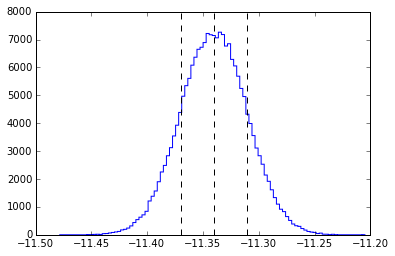

In [13]:
"""
We're done, so see what the results look like.  To do this, we need to combine
 the nwalkers chains together.  Do this with the flatchain method.
 
Start with a0, and plot it
"""
a0s = sampler.flatchain[:,0]
tmp = plt.hist(a0s,bins=100,histtype='step')

""" Estimate the 68% range, as well as the median point """
a0s.sort()
a0m = a0s[int(0.16 * a0s.size)]
a0p = a0s[int(0.84 * a0s.size)]
a0med = a0s[int(0.5 * a0s.size)]
axvline(a0m,color='k',linestyle='dashed')
axvline(a0p,color='k',linestyle='dashed')
axvline(a0med,color='k',linestyle='dashed')
print ''
print 'a0 = %6.2f.' % a0med
print '  68 percent CL: %6.2f - %6.2f' % (a0m,a0p)
print ''


a1 =   0.2672.
  68 percent CL:   0.2665 -   0.2679



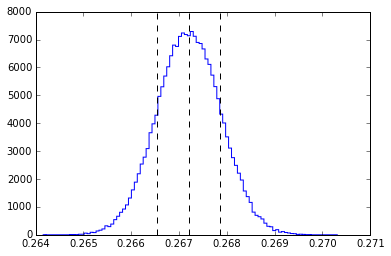

In [14]:
""" Now do a1 """
a1s = sampler.flatchain[:,1]
tmp = hist(a1s,bins=100,histtype='step')

""" Estimate the 68% range, as well as the median point """
a1s.sort()
a1m = a1s[int(0.16 * a1s.size)]
a1p = a1s[int(0.84 * a1s.size)]
a1med = a1s[int(0.5 * a1s.size)]
axvline(a1m,color='k',linestyle='dashed')
axvline(a1p,color='k',linestyle='dashed')
axvline(a1med,color='k',linestyle='dashed')
print ''
print 'a1 = %8.4f.' % a1med
print '  68 percent CL: %8.4f - %8.4f' % (a1m,a1p)
print ''

(-0.5, 2)

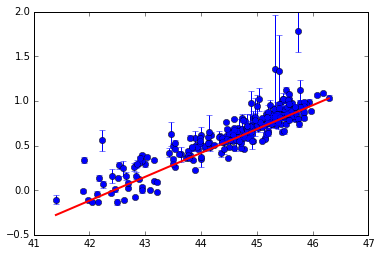

In [15]:
""" Make a plot using the median values for a0 and a1 """
xmod = np.linspace(x.min(),x.max(),100)
ymod = a0med + a1med * xmod
plot(x,y,'bo')
errorbar(x,y,yerr,fmt='none')
plot(xmod,ymod,'r',lw=2)
ylim(-0.5,2)

/Users/cdf/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


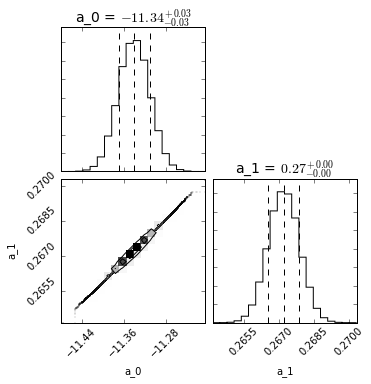

In [16]:
"""
Finally (although there is one non-used but possibly interesting bit of code at the end)
make a nice plot using corner.py
Often, after doing a MCMC analysis, a corner plot is the best way of presenting the results.
Here, follow the syntax from the emcee page, but with some of the extra bells and whistles
from the corner.py page
"""
samples = sampler.chain.reshape((-1,ndims))
plt.figure(figsize=(9,9))
fig = corner.corner(samples,labels=['a_0','a_1'],quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,title_kwargs={"fontsize": 14})

In [27]:
"""
Set up a class that evaluates your model and returns a ln(likelihood)

NOTE: This is an alternative way of doing things that may be slightly more elegant, but
 also slightly more confusing.  It is not actually used in the code above.
"""

class LinearModel(object):
    """
    Does a simple fit of a line to the data.  
    For this class, when you initialize it, you pass it your data as the
     typical x, y, and error on y.
    You could, of course, initialize it in a different way, e.g., by passing
     it the name of the file that contained the data.
    """
    def __init__(self,x,y,yerr):
        """
        This method is used when you type something like:
           foo = LinearModel(x,y,yerr)
        and it creates an "instance" of this class that you can then use for
        other things.
        """
        self.x = x
        self.y = y
        self.yerr = yerr
        
    def __call__(self,pars):
        """ 
        This method takes a set of parameters for a previously initialized
        instance of the class and
          (1) Creates a y_model from the parameters and the x array
          (2) Calculates ln(L), which is just -chi^2 under the assumption of Gaussian
              distributed errors
          (3) returns ln(L) to the calling function
        In looking at the code below, you can see that the model is
           y_model = a_0 + a_1 x
        and the pars array is set up to be pars = [a_0, a_1]
        """
        y_model = pars[0] + pars[1]*self.x
        logl = -(self.y -y_model)**2/self.yerr**2
        return logl.sum()
